**Machine Learning Models for Anti-Money Laundering Detection**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
df = pd.read_parquet('../data/Gold/features_engineered.parquet')
print(f" Dataloaded with: {df.shape}")

 Dataloaded with: (31898218, 32)


In [3]:

print(f"Laundering rate: {df['Is Laundering'].mean()*100:.4f}%")
print(f"\nColumns: {list(df.columns)}")

Laundering rate: 0.1104%

Columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'hour', 'day_of_week', 'date', 'is_weekend', 'is_night', 'is_cross_currency', 'is_round_1000', 'is_round_100', 'is_ach', 'is_just_below_threshold', 'in_structuring_range', 'amount_zscore', 'account_prefix', 'is_bank_1004', 'is_bank_800', 'is_uk_pound', 'is_euro', 'is_usd', 'uk_pound_structuring', 'ach_weekend', 'risk_score_v2']


 Feature Selection & Preprocessing

- Statistical Tests for Feature Selection

In [4]:
from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import chi2, f_classif



categorical_features = []
numerical_features = []

exclude_cols = ['Is Laundering', 'Timestamp', 'Account', 'Account.1', 'date', 'account_prefix']

for col in df.columns:
    if col in exclude_cols:
        continue
    
    dtype = df[col].dtype
    
    if dtype == 'category' or dtype == 'object':
        categorical_features.append(col)
    elif dtype in ['int32', 'int64'] and df[col].nunique() <= 50: 
        categorical_features.append(col)
    elif dtype in ['float32', 'float64', 'int32', 'int64']:
        numerical_features.append(col)

In [5]:

print(f"\nDetected {len(categorical_features)} categorical features")
print(f"Detected {len(numerical_features)} numerical features")


Detected 21 categorical features
Detected 5 numerical features


In [6]:
#  features based on EDA findings
feature_cols = [
    'From Bank', 'To Bank',
    'Amount Received', 'Amount Paid', 'amount_zscore',
    'is_uk_pound', 'is_euro', 'is_usd',
    'hour', 'day_of_week', 'is_weekend', 'is_night',
    'is_ach', 
    'is_just_below_threshold', 'in_structuring_range', 
    'is_bank_1004', 'is_bank_800',
    'uk_pound_structuring', 'ach_weekend', 
    'risk_score_v2'
]

In [7]:

# CHI-SQUARED TESTS for categorical features

chi2_results = []

for feat in categorical_features:
    try:
        contingency = pd.crosstab(df[feat], df['Is Laundering'])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
        
        laundering_rates = df.groupby(feat)['Is Laundering'].mean() * 100
        if len(laundering_rates) == 2:
            risk_multiplier = laundering_rates.iloc[1] / laundering_rates.iloc[0] if laundering_rates.iloc[0] > 0 else np.inf
        else:
            risk_multiplier = laundering_rates.max() / laundering_rates.min() if laundering_rates.min() > 0 else np.inf
        
        chi2_results.append({
            'Feature': feat,
            'Data_Type': str(df[feat].dtype),
            'Chi2_Statistic': chi2_stat,
            'P_Value': p_value,
            'Risk_Multiplier': risk_multiplier,
            'Unique_Values': df[feat].nunique()
        })
    except Exception as e:
        print(f"  Warning: Could not test {feat}: {e}")

In [8]:
chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2_Statistic', ascending=False)
chi2_df['Significance'] = chi2_df['P_Value'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns')))
chi2_df['Status'] = chi2_df['Feature'].apply(lambda x: 'INCLUDED' if x in feature_cols else 'EXCLUDED')

print("Features Ranked by Chi-Squared Statistic")
chi2_df

Features Ranked by Chi-Squared Statistic


,Feature,Data_Type,Chi2_Statistic,P_Value,Risk_Multiplier,Unique_Values,Significance,Status
20,risk_score_v2,int64,284328.0305,0.0000,inf,18,***,INCLUDED
2,Payment Format,category,186990.1700,0.0000,inf,7,***,EXCLUDED
10,is_ach,int64,186876.9346,0.0000,49.6834,2,***,INCLUDED
19,ach_weekend,int64,129306.1929,0.0000,21.6438,2,***,INCLUDED
4,day_of_week,int32,11237.6261,0.0000,4.1837,7,***,INCLUDED
5,is_weekend,int64,9321.8412,0.0000,3.0404,2,***,INCLUDED
3,hour,int32,5815.2662,0.0000,5.4902,24,***,INCLUDED
12,in_structuring_range,int64,5742.3435,0.0000,2.4372,2,***,INCLUDED
0,Receiving Currency,category,3471.3179,0.0000,4.5708,15,***,EXCLUDED
1,Payment Currency,category,3380.3441,0.0000,4.5154,15,***,EXCLUDED


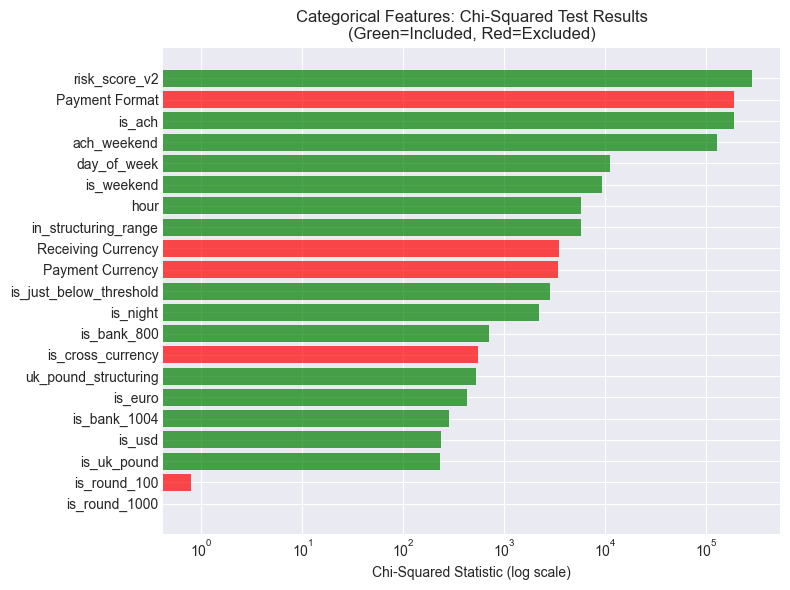

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['green' if status == 'INCLUDED' else 'red' for status in chi2_df['Status']]
ax.barh(chi2_df['Feature'], chi2_df['Chi2_Statistic'], color=colors, alpha=0.7)
ax.set_xlabel('Chi-Squared Statistic (log scale)')
ax.set_title('Categorical Features: Chi-Squared Test Results\n(Green=Included, Red=Excluded)')
ax.set_xscale('log')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# ANOVA F-TESTS for all numerical featuers

anova_results = []

for feat in numerical_features:
    try:
        group_0 = df[df['Is Laundering'] == 0][feat].dropna()
        group_1 = df[df['Is Laundering'] == 1][feat].dropna()
        
        f_stat, p_value = f_oneway(group_0, group_1)
        
        mean_0 = group_0.mean()
        mean_1 = group_1.mean()
        
        anova_results.append({
            'Feature': feat,
            'Data_Type': str(df[feat].dtype),
            'F_Statistic': f_stat,
            'P_Value': p_value,
            'Mean_Normal': mean_0,
            'Mean_Laundering': mean_1,
            'Difference': mean_1 - mean_0
        })
    except Exception as e:
        print(f"  Warning: Could not test {feat}: {e}")

In [11]:

anova_df = pd.DataFrame(anova_results).sort_values('F_Statistic', ascending=False)
anova_df['Significance'] = anova_df['P_Value'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns')))
anova_df['Status'] = anova_df['Feature'].apply(lambda x: 'INCLUDED' if x in feature_cols else 'EXCLUDED')

print("Numerical Features Ranked by F-Statistic:")
anova_df

Numerical Features Ranked by F-Statistic:


,Feature,Data_Type,F_Statistic,P_Value,Mean_Normal,Mean_Laundering,Difference,Significance,Status
1,To Bank,int32,3316.8842,0.0000,409541.3952,208554.1628,-200987.2324,***,INCLUDED
0,From Bank,int32,1673.5234,0.0000,294557.5883,160378.2840,-134179.3043,***,INCLUDED
3,Amount Paid,float32,24.4845,0.0000,4363706.0000,53116740.0000,48753032.0000,***,INCLUDED
4,amount_zscore,float32,24.4844,0.0000,-0.0000,0.0263,0.0264,***,INCLUDED
2,Amount Received,float32,11.4352,0.0007,6379509.5000,53116740.0000,46737232.0000,***,INCLUDED


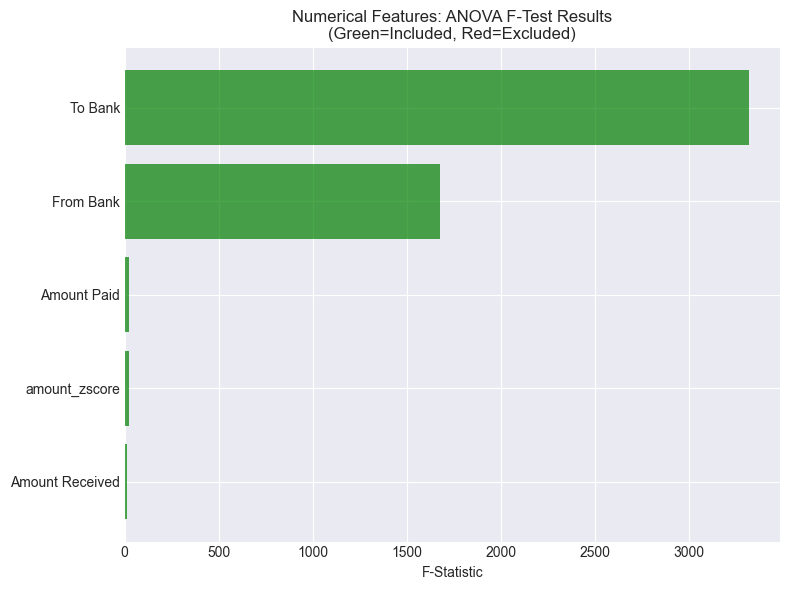

In [12]:

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['green' if status == 'INCLUDED' else 'red' for status in anova_df['Status']]
ax.barh(anova_df['Feature'], anova_df['F_Statistic'], color=colors, alpha=0.7)
ax.set_xlabel('F-Statistic')
ax.set_title('Numerical Features: ANOVA F-Test Results\n(Green=Included, Red=Excluded)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:

# excluded features with reasons
excluded_features = {
    'is_round_1000': 'Weak signal (low Chi2)',
    'is_round_100': 'Weak signal (low Chi2)',
    'Payment Format': 'Redundant (encoded as is_ach)',
    'Receiving Currency': 'Redundant (encoded as currency flags)',
    'Payment Currency': 'Redundant (encoded as currency flags)',
}

justification_data = []
for feat, reason in excluded_features.items():
    if feat in chi2_df['Feature'].values:
        row = chi2_df[chi2_df['Feature'] == feat].iloc[0]
        justification_data.append({
            'Feature': feat,
            'Data_Type': row['Data_Type'],
            'Chi2_Statistic': row['Chi2_Statistic'],
            'P_Value': row['P_Value'],
            'Risk_Multiplier': row['Risk_Multiplier'],
            'Reason_Excluded': reason
        })

justification_df = pd.DataFrame(justification_data)
print("Excluded Features with Statistical Evidence:")
justification_df

Excluded Features with Statistical Evidence:


,Feature,Data_Type,Chi2_Statistic,P_Value,Risk_Multiplier,Reason_Excluded
0,is_round_1000,int64,0.0000,1.0000,0.9627,Weak signal (low Chi2)
1,is_round_100,int64,0.7966,0.3721,1.2549,Weak signal (low Chi2)
2,Payment Format,category,186990.1700,0.0000,inf,Redundant (encoded as is_ach)
3,Receiving Currency,category,3471.3179,0.0000,4.5708,Redundant (encoded as currency flags)
4,Payment Currency,category,3380.3441,0.0000,4.5154,Redundant (encoded as currency flags)


Train/Test Split (Time-Based)

In [14]:
feature_cols

['From Bank',
 'To Bank',
 'Amount Received',
 'Amount Paid',
 'amount_zscore',
 'is_uk_pound',
 'is_euro',
 'is_usd',
 'hour',
 'day_of_week',
 'is_weekend',
 'is_night',
 'is_ach',
 'is_just_below_threshold',
 'in_structuring_range',
 'is_bank_1004',
 'is_bank_800',
 'uk_pound_structuring',
 'ach_weekend',
 'risk_score_v2']

In [15]:
from sklearn.preprocessing import StandardScaler


df_sorted = df.sort_values('Timestamp').reset_index(drop=True)

split_idx = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df['Is Laundering']
X_test = test_df[feature_cols]
y_test = test_df['Is Laundering']

In [16]:
print(f"Training set: {X_train.shape}")
print(f"  Time range: {train_df['Timestamp'].min()} to {train_df['Timestamp'].max()}")
print(f"  Laundering rate: {y_train.mean()*100:.4f}%")

Training set: (25518574, 20)
  Time range: 2022-09-01 00:00:00 to 2022-09-14 05:46:00
  Laundering rate: 0.0964%


In [17]:
print(f"\nTest set: {X_test.shape}")
print(f"  Time range: {test_df['Timestamp'].min()} to {test_df['Timestamp'].max()}")
print(f"  Laundering rate: {y_test.mean()*100:.4f}%")


Test set: (6379644, 20)
  Time range: 2022-09-14 05:46:00 to 2022-09-28 15:58:00
  Laundering rate: 0.1668%


In [18]:
print(f"\nTrain class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())


Train class distribution:
Is Laundering
0    25493985
1       24589
Name: count, dtype: int64

Test class distribution:
Is Laundering
0    6369003
1      10641
Name: count, dtype: int64


Model 1: XGBoost with Class Weighting

Feature Scaling

In [20]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(f"Features scaled using StandardScaler")

Features scaled using StandardScaler


scale_pos_weight


In [21]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}\n")


Scale pos weight: 1036.80



Training

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

model1 = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
model1.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Predictions

In [23]:


y_pred1 = model1.predict(X_test_scaled)
y_proba1 = model1.predict_proba(X_test_scaled)[:, 1]

print("\nModel 1: XGBoost with Class Weighting")
print(classification_report(y_test, y_pred1))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred1):.4f}")


Model 1: XGBoost with Class Weighting
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   6369003
           1       0.01      0.98      0.02     10641

    accuracy                           0.83   6379644
   macro avg       0.50      0.90      0.46   6379644
weighted avg       1.00      0.83      0.91   6379644


ROC-AUC Score: 0.9761
F1 Score: 0.0189
Precision: 0.0095
Recall: 0.9797


Model 2: Unsampling + XGBoost

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler_10 = RandomUnderSampler(sampling_strategy=0.1, random_state=42)  #1:10 ratio
X_train_under10, y_train_under10 = undersampler_10.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {X_train_scaled.shape}")
print(f"Undersampled (1:10) training set: {X_train_under10.shape}")
print(f"\nClass distribution:")
print(pd.Series(y_train_under10).value_counts())


Original training set: (25518574, 20)
Undersampled (1:10) training set: (270479, 20)

Class distribution:
Is Laundering
0    245890
1     24589
Name: count, dtype: int64


Train

In [29]:

# Train model with 1:10 ratio
undersamplingModel = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

undersamplingModel.fit(X_train_under10, y_train_under10)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:


y_pred2b = undersamplingModel.predict(X_test_scaled)
y_proba2b = undersamplingModel.predict_proba(X_test_scaled)[:, 1]

print("\nModel 2b: XGBoost with Undersampling (1:10 ratio)")

print(classification_report(y_test, y_pred2b))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba2b):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred2b):.4f}")
print(f"Precision: {precision_score(y_test, y_pred2b):.4f}")
print(f"Recall: {recall_score(y_test, y_pred2b):.4f}")


Model 2b: XGBoost with Undersampling (1:10 ratio)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6369003
           1       0.07      0.68      0.13     10641

    accuracy                           0.98   6379644
   macro avg       0.54      0.83      0.56   6379644
weighted avg       1.00      0.98      0.99   6379644


ROC-AUC Score: 0.9757
F1 Score: 0.1302
Precision: 0.0720
Recall: 0.6795


In [27]:

# Predict on original test set (not undersampled)
y_pred2 = undersamplingModel.predict(X_test_scaled)
y_proba2 = undersamplingModel.predict_proba(X_test_scaled)[:, 1]

print("\nModel 2: XGBoost with Undersampling")

print(classification_report(y_test, y_pred2))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba2):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred2):.4f}")


Model 2: XGBoost with Undersampling
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   6369003
           1       0.01      0.98      0.02     10641

    accuracy                           0.82   6379644
   macro avg       0.50      0.90      0.46   6379644
weighted avg       1.00      0.82      0.90   6379644


ROC-AUC Score: 0.9744
F1 Score: 0.0183
Precision: 0.0092
Recall: 0.9817


Model 3: LightGBM with Class Weight

In [ ]:
from lightgbm import LGBMClassifier

# Model 3: LightGBM with Class Weight
model3 = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model3.fit(X_train_scaled, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [33]:


# Predictions
y_pred3 = model3.predict(X_test_scaled)
y_proba3 = model3.predict_proba(X_test_scaled)[:, 1]

print("\nModel 3: LightGBM with Class Weighting")

print(classification_report(y_test, y_pred3))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba3):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred3):.4f}")
print(f"Precision: {precision_score(y_test, y_pred3):.4f}")
print(f"Recall: {recall_score(y_test, y_pred3):.4f}")


Model 3: LightGBM with Class Weighting
              precision    recall  f1-score   support

           0       1.00      0.86      0.92   6369003
           1       0.01      0.85      0.02     10641

    accuracy                           0.86   6379644
   macro avg       0.50      0.85      0.47   6379644
weighted avg       1.00      0.86      0.92   6379644


ROC-AUC Score: 0.8542
F1 Score: 0.0193
Precision: 0.0098
Recall: 0.8531


Model 4: LightGBM with Undersampling 

In [34]:
model4 = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model4.fit(X_train_under10, y_train_under10) #1:10 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [35]:



y_pred4 = model4.predict(X_test_scaled)
y_proba4 = model4.predict_proba(X_test_scaled)[:, 1]

print("\nModel 4: LightGBM with Undersampling (1:10 ratio)")
print(classification_report(y_test, y_pred4))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba4):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred4):.4f}")
print(f"Precision: {precision_score(y_test, y_pred4):.4f}")
print(f"Recall: {recall_score(y_test, y_pred4):.4f}")


Model 4: LightGBM with Undersampling (1:10 ratio)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6369003
           1       0.07      0.68      0.13     10641

    accuracy                           0.98   6379644
   macro avg       0.54      0.83      0.56   6379644
weighted avg       1.00      0.98      0.99   6379644


ROC-AUC Score: 0.9758
F1 Score: 0.1289
Precision: 0.0712
Recall: 0.6779


Model 5: Ensemble (best XGBoost + best LightGBM)

In [37]:
y_proba_ensemble = (y_proba2b + y_proba4) / 2
y_pred_ensemble = (y_proba_ensemble >= 0.5).astype(int)

print("\nModel 5: Ensemble (XGBoost + LightGBM with 1:10 Undersampling)")

print(classification_report(y_test, y_pred_ensemble))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_ensemble):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble):.4f}")


Model 5: Ensemble (XGBoost + LightGBM with 1:10 Undersampling)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6369003
           1       0.07      0.68      0.13     10641

    accuracy                           0.98   6379644
   macro avg       0.54      0.83      0.56   6379644
weighted avg       1.00      0.98      0.99   6379644


ROC-AUC Score: 0.9758
F1 Score: 0.1305
Precision: 0.0722
Recall: 0.6790


Model performance is still down .

Threshold Tuning on Model 2b  FASTEST & MOST PRACTICAL

In [38]:
# tune thresholds to optimize precision/recall trade-off

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba2b >= threshold).astype(int)
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1': f1_score(y_test, y_pred_thresh),
        'ROC-AUC': roc_auc_score(y_test, y_proba2b)
    })

threshold_df = pd.DataFrame(threshold_results)
print("Threshold Tuning Results for Model 2b")
print(threshold_df)

Threshold Tuning Results for Model 2b
   Threshold  Precision  Recall     F1  ROC-AUC
0     0.3000     0.0334  0.8308 0.0642   0.9757
1     0.4000     0.0479  0.7628 0.0901   0.9757
2     0.5000     0.0720  0.6795 0.1302   0.9757
3     0.6000     0.1079  0.5821 0.1821   0.9757
4     0.7000     0.1623  0.4664 0.2408   0.9757


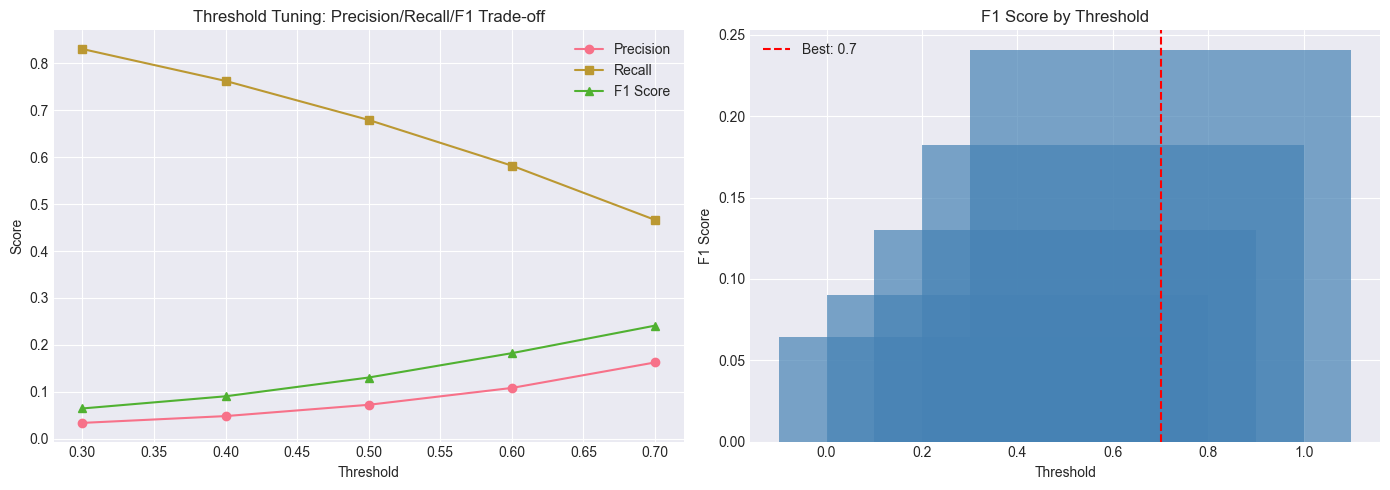

In [40]:
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(threshold_df['Threshold'], threshold_df['Precision'], marker='o', label='Precision')
ax[0].plot(threshold_df['Threshold'], threshold_df['Recall'], marker='s', label='Recall')
ax[0].plot(threshold_df['Threshold'], threshold_df['F1'], marker='^', label='F1 Score')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Score')
ax[0].set_title('Threshold Tuning: Precision/Recall/F1 Trade-off')
ax[0].legend()
ax[0].grid(True)

ax[1].bar(threshold_df['Threshold'], threshold_df['F1'], color='steelblue', alpha=0.7)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score by Threshold')
ax[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold}')
ax[1].legend()

plt.tight_layout()
plt.show()

In [41]:
# Threshold Tuning on Model 4 (LightGBM with 1:10 Undersampling)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results_lgbm = []

for threshold in thresholds:
    y_pred_thresh = (y_proba4 >= threshold).astype(int)
    
    threshold_results_lgbm.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1': f1_score(y_test, y_pred_thresh),
        'ROC-AUC': roc_auc_score(y_test, y_proba4)
    })

threshold_df_lgbm = pd.DataFrame(threshold_results_lgbm)
print("Threshold Tuning Results for Model 4 (LightGBM)")

print(threshold_df_lgbm)

Threshold Tuning Results for Model 4 (LightGBM)
   Threshold  Precision  Recall     F1  ROC-AUC
0     0.3000     0.0332  0.8322 0.0638   0.9758
1     0.4000     0.0478  0.7645 0.0900   0.9758
2     0.5000     0.0712  0.6779 0.1289   0.9758
3     0.6000     0.1079  0.5840 0.1821   0.9758
4     0.7000     0.1599  0.4618 0.2375   0.9758


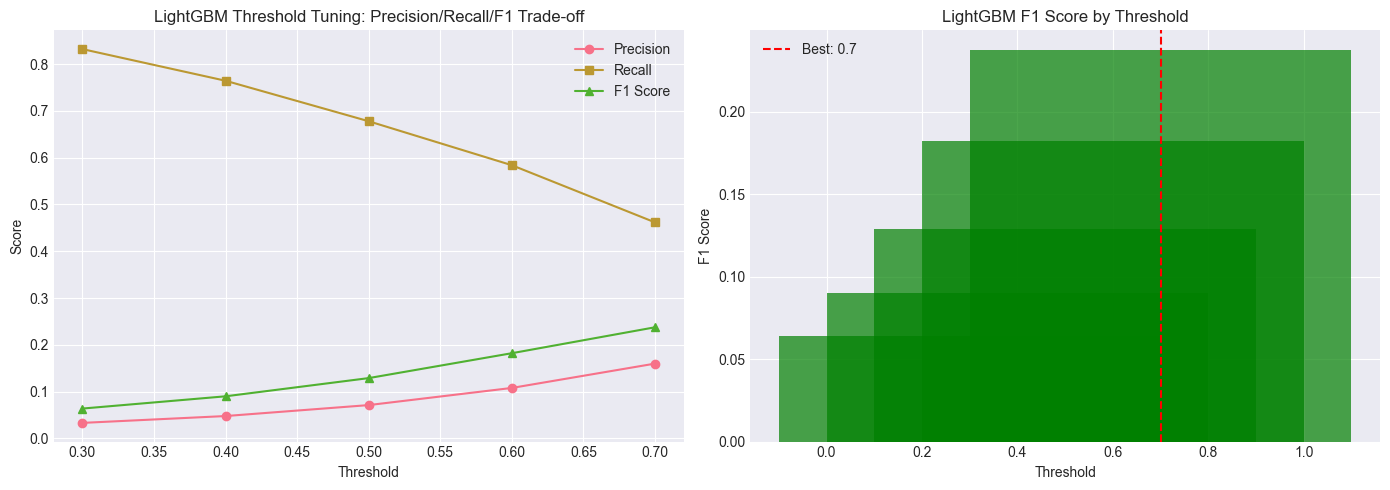

In [43]:
# Visualize
best_threshold_lgbm = threshold_df_lgbm.loc[threshold_df_lgbm['F1'].idxmax(), 'Threshold']


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(threshold_df_lgbm['Threshold'], threshold_df_lgbm['Precision'], marker='o', label='Precision')
ax[0].plot(threshold_df_lgbm['Threshold'], threshold_df_lgbm['Recall'], marker='s', label='Recall')
ax[0].plot(threshold_df_lgbm['Threshold'], threshold_df_lgbm['F1'], marker='^', label='F1 Score')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Score')
ax[0].set_title('LightGBM Threshold Tuning: Precision/Recall/F1 Trade-off')
ax[0].legend()
ax[0].grid(True)

ax[1].bar(threshold_df_lgbm['Threshold'], threshold_df_lgbm['F1'], color='green', alpha=0.7)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('LightGBM F1 Score by Threshold')
ax[1].axvline(x=best_threshold_lgbm, color='red', linestyle='--', label=f'Best: {best_threshold_lgbm}')
ax[1].legend()

plt.tight_layout()
plt.show()

Model 6: CatBoost with 1:10 Undersampling

In [44]:

from catboost import CatBoostClassifier

model_catboost = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False,
    thread_count=-1
)
model_catboost.fit(X_train_under10, y_train_under10)

In [45]:


y_pred_catboost = model_catboost.predict(X_test_scaled)
y_proba_catboost = model_catboost.predict_proba(X_test_scaled)[:, 1]

print("Model 6: CatBoost with Undersampling (1:10 ratio)")

print(classification_report(y_test, y_pred_catboost))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_catboost):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_catboost):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_catboost):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_catboost):.4f}")

Model 6: CatBoost with Undersampling (1:10 ratio)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   6369003
           1       0.07      0.68      0.12     10641

    accuracy                           0.98   6379644
   macro avg       0.53      0.83      0.56   6379644
weighted avg       1.00      0.98      0.99   6379644


ROC-AUC Score: 0.9751
F1 Score: 0.1231
Precision: 0.0676
Recall: 0.6820


Threshold Tuning on CatBoost (Model 6)

In [47]:


thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results_catboost = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_catboost >= threshold).astype(int)
    
    threshold_results_catboost.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1': f1_score(y_test, y_pred_thresh),
        'ROC-AUC': roc_auc_score(y_test, y_proba_catboost)
    })

threshold_df_catboost = pd.DataFrame(threshold_results_catboost)
print("Threshold Tuning Results for Model 6 (CatBoost)")
print(threshold_df_catboost)

Threshold Tuning Results for Model 6 (CatBoost)
   Threshold  Precision  Recall     F1  ROC-AUC
0     0.3000     0.0330  0.8253 0.0634   0.9751
1     0.4000     0.0458  0.7616 0.0863   0.9751
2     0.5000     0.0676  0.6820 0.1231   0.9751
3     0.6000     0.1011  0.5873 0.1725   0.9751
4     0.7000     0.1531  0.4717 0.2312   0.9751


In [ ]:

best_threshold_catboost = threshold_df_catboost.loc[threshold_df_catboost['F1'].idxmax(), 'Threshold']


# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(threshold_df_catboost['Threshold'], threshold_df_catboost['Precision'], marker='o', label='Precision')
ax[0].plot(threshold_df_catboost['Threshold'], threshold_df_catboost['Recall'], marker='s', label='Recall')
ax[0].plot(threshold_df_catboost['Threshold'], threshold_df_catboost['F1'], marker='^', label='F1 Score')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Score')
ax[0].set_title('CatBoost Threshold Tuning: Precision/Recall/F1 Trade-off')
ax[0].legend()
ax[0].grid(True)

ax[1].bar(threshold_df_catboost['Threshold'], threshold_df_catboost['F1'], color='orange', alpha=0.7)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('CatBoost F1 Score by Threshold')
ax[1].axvline(x=best_threshold_catboost, color='red', linestyle='--', label=f'Best: {best_threshold_catboost}')
ax[1].legend()

plt.tight_layout()
plt.show()

Cost-Sensitive Learning

In [48]:
cost_fn = 100  # Cost of False Negative (missing laundering)
cost_fp = 1    # Cost of False Positive (false alarm)

print("Cost-Sensitive Learning with Custom Cost Matrix")
print(f"False Negative Cost: {cost_fn}x")
print(f"False Positive Cost: {cost_fp}x")

Cost-Sensitive Learning with Custom Cost Matrix
False Negative Cost: 100x
False Positive Cost: 1x


- Cost-Sensitive on FULL DATA (with class weighting)

In [50]:
scale_pos_weight_cost_full = cost_fn / cost_fp  
print(f"\nCost-Sensitive on Full Data")
print(f"  scale_pos_weight: {scale_pos_weight_cost_full:.2f}")

model_cost_full = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_cost_full,
    random_state=42,
    n_jobs=-1
)
model_cost_full.fit(X_train_scaled, y_train)


Cost-Sensitive on Full Data
  scale_pos_weight: 100.00


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [51]:
y_pred_cost_full = model_cost_full.predict(X_test_scaled)
y_proba_cost_full = model_cost_full.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost Cost-Sensitive (Full Data)")
print(classification_report(y_test, y_pred_cost_full))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_cost_full):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cost_full):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cost_full):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_cost_full):.4f}")


XGBoost Cost-Sensitive (Full Data)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6369003
           1       0.08      0.68      0.14     10641

    accuracy                           0.99   6379644
   macro avg       0.54      0.83      0.57   6379644
weighted avg       1.00      0.99      0.99   6379644


ROC-AUC Score: 0.9763
F1 Score: 0.1396
Precision: 0.0778
Recall: 0.6753


- Cost-Sensitive on 1:10 UNDERSAMPLED DATA

In [52]:
scale_pos_weight_cost_under = cost_fn / cost_fp * ((y_train_under10 == 0).sum() / (y_train_under10 == 1).sum())
print(f"\n\nCost-Sensitive on 1:10 Undersampled Data")
print(f"  scale_pos_weight: {scale_pos_weight_cost_under:.2f}")

model_cost_under = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_cost_under,
    random_state=42,
    n_jobs=-1
)
model_cost_under.fit(X_train_under10, y_train_under10)



Cost-Sensitive on 1:10 Undersampled Data
  scale_pos_weight: 1000.00


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [53]:

y_pred_cost_under = model_cost_under.predict(X_test_scaled)
y_proba_cost_under = model_cost_under.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost Cost-Sensitive (1:10 Undersampling)")
print(classification_report(y_test, y_pred_cost_under))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_cost_under):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cost_under):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cost_under):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_cost_under):.4f}")


XGBoost Cost-Sensitive (1:10 Undersampling)
              precision    recall  f1-score   support

           0       1.00      0.76      0.86   6369003
           1       0.01      1.00      0.01     10641

    accuracy                           0.76   6379644
   macro avg       0.50      0.88      0.44   6379644
weighted avg       1.00      0.76      0.86   6379644


ROC-AUC Score: 0.9751
F1 Score: 0.0138
Precision: 0.0069
Recall: 0.9971


Tune threshold Cost-Sensitive on FULL DATA (with class weighting) to see if it beats Model 2b (XGB 1:10 Under) 24.08% F1

In [54]:

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results_cost = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_cost_full >= threshold).astype(int)
    
    threshold_results_cost.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1': f1_score(y_test, y_pred_thresh),
        'ROC-AUC': roc_auc_score(y_test, y_proba_cost_full)
    })

threshold_df_cost = pd.DataFrame(threshold_results_cost)
print("Threshold Tuning Results for Model 7a (Cost-Sensitive Full Data)")
print(threshold_df_cost)

Threshold Tuning Results for Model 7a (Cost-Sensitive Full Data)
   Threshold  Precision  Recall     F1  ROC-AUC
0     0.3000     0.0353  0.8228 0.0678   0.9763
1     0.4000     0.0518  0.7567 0.0970   0.9763
2     0.5000     0.0778  0.6753 0.1396   0.9763
3     0.6000     0.1175  0.5771 0.1953   0.9763
4     0.7000     0.1783  0.4576 0.2566   0.9763


Calibrated LightGBM

In [55]:
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV

print("Calibrated LightGBM ")

model8_base = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=256,
    colsample_bytree=0.7,
    subsample=0.8,
    reg_lambda=1.0,
    scale_pos_weight=1,  # NO class weighting
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
model8_base.fit(X_train_scaled, y_train)

Calibrated LightGBM 


,boosting_type,'gbdt'
,num_leaves,256
,max_depth,8
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [56]:
# Calibrate probabilities using sigmoid
print("Calibrating probabilities with CalibratedClassifierCV...")
model8_calibrated = CalibratedClassifierCV(model8_base, method='sigmoid', cv=3)
model8_calibrated.fit(X_train_scaled, y_train)

y_proba8 = model8_calibrated.predict_proba(X_test_scaled)[:, 1]

# Business-driven threshold: top 0.5% of transactions
threshold_business = np.percentile(y_proba8, 99.5)
y_pred8 = (y_proba8 >= threshold_business).astype(int)

Calibrating probabilities with CalibratedClassifierCV...


In [57]:
print(f"\nBusiness Threshold (top 0.5%): {threshold_business:.4f}")
print(f"Expected alerts per day: ~{len(y_test) * 0.005 / 14:.0f} (14-day test period)")


Business Threshold (top 0.5%): 0.0013
Expected alerts per day: ~2278 (14-day test period)


In [58]:
print("\nModel 8: Calibrated LightGBM (Business Threshold)")
print(classification_report(y_test, y_pred8))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba8):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred8):.4f}")
print(f"Precision: {precision_score(y_test, y_pred8):.4f}")
print(f"Recall: {recall_score(y_test, y_pred8):.4f}")


Model 8: Calibrated LightGBM (Business Threshold)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6369003
           1       0.19      0.56      0.28     10641

    accuracy                           1.00   6379644
   macro avg       0.59      0.78      0.64   6379644
weighted avg       1.00      1.00      1.00   6379644


ROC-AUC Score: 0.9781
F1 Score: 0.2808
Precision: 0.1872
Recall: 0.5613


In [59]:
# Threshold Optimization Calibrated LightGBM
print("Threshold Tuning on Calibrated LightGBM")

thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_t = (y_proba8 >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    results.append({
        'threshold': thresh,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    print(f"Threshold {thresh:.2f}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

Threshold Tuning on Calibrated LightGBM
Threshold 0.10: Precision=0.7275, Recall=0.1887, F1=0.2997
Threshold 0.15: Precision=0.7603, Recall=0.1723, F1=0.2809
Threshold 0.20: Precision=0.7876, Recall=0.1585, F1=0.2639
Threshold 0.25: Precision=0.8112, Recall=0.1454, F1=0.2466
Threshold 0.30: Precision=0.8335, Recall=0.1346, F1=0.2317
Threshold 0.35: Precision=0.8565, Recall=0.1162, F1=0.2046
Threshold 0.40: Precision=0.8738, Recall=0.1048, F1=0.1871
Threshold 0.45: Precision=0.8895, Recall=0.0984, F1=0.1772
Threshold 0.50: Precision=0.8966, Recall=0.0904, F1=0.1642
Threshold 0.55: Precision=0.9061, Recall=0.0835, F1=0.1528
Threshold 0.60: Precision=0.9194, Recall=0.0750, F1=0.1387
Threshold 0.65: Precision=0.9428, Recall=0.0635, F1=0.1190
Threshold 0.70: Precision=0.9615, Recall=0.0423, F1=0.0810
Threshold 0.75: Precision=0.9681, Recall=0.0371, F1=0.0715
Threshold 0.80: Precision=0.9694, Recall=0.0328, F1=0.0634
Threshold 0.85: Precision=0.9721, Recall=0.0295, F1=0.0573
Threshold 0.90: 

In [62]:
#  predictions with best threshold

best_result = max(results, key=lambda x: x['f1'])
best_threshold = best_result['threshold']
y_pred8_tuned = (y_proba8 >= best_threshold).astype(int)

print("\nCalibrated LightGBM (Optimized Threshold)")

print(classification_report(y_test, y_pred8_tuned))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba8):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred8_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred8_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred8_tuned):.4f}")



Calibrated LightGBM (Optimized Threshold)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6369003
           1       0.73      0.19      0.30     10641

    accuracy                           1.00   6379644
   macro avg       0.86      0.59      0.65   6379644
weighted avg       1.00      1.00      1.00   6379644


ROC-AUC Score: 0.9781
F1 Score: 0.2997
Precision: 0.7275
Recall: 0.1887


In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred8_tuned)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix Breakdown:")

print(f"True Negatives (TN):  {tn:,} (correctly identified normal transactions)")
print(f"False Positives (FP): {fp:,} (normal flagged as laundering)")
print(f"False Negatives (FN): {fn:,} (laundering missed)")
print(f"True Positives (TP):  {tp:,} (correctly identified laundering)")
print(f"\nFalse Positive Rate: {fp/(fp+tn):.2%}")
print(f"False Negative Rate: {fn/(fn+tp):.2%}")
print(f"True Positive Rate (Recall): {tp/(tp+fn):.2%}")
print(f"Precision: {tp/(tp+fp):.2%}")

Confusion Matrix Breakdown:
True Negatives (TN):  6,368,251 (correctly identified normal transactions)
False Positives (FP): 752 (normal flagged as laundering)
False Negatives (FN): 8,633 (laundering missed)
True Positives (TP):  2,008 (correctly identified laundering)

False Positive Rate: 0.01%
False Negative Rate: 81.13%
True Positive Rate (Recall): 18.87%
Precision: 72.75%


Anomaly Detection: Isolation Forest model

- Undesampling

In [70]:

from sklearn.ensemble import IsolationForest

print("Training Isolation Forest on normal transactions only...")

X_train_normal = X_train_under10[y_train_under10 == 0]

model_anomaly = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=42,
    n_jobs=-1
)

model_anomaly.fit(X_train_normal)

Training Isolation Forest on normal transactions only...


Python(80007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [71]:

# Prediction
y_pred_anomaly_raw = model_anomaly.predict(X_test_scaled)
y_pred_anomaly = (y_pred_anomaly_raw == -1).astype(int)

y_score_anomaly = model_anomaly.score_samples(X_test_scaled)
y_proba_anomaly = 1 - (y_score_anomaly - y_score_anomaly.min()) / (y_score_anomaly.max() - y_score_anomaly.min())


In [72]:
print("\n Isolation Forest (Anomaly Detection)")

print(classification_report(y_test, y_pred_anomaly))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_anomaly):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_anomaly):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_anomaly):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_anomaly):.4f}")


 Isolation Forest (Anomaly Detection)
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   6369003
           1       0.01      0.46      0.02     10641

    accuracy                           0.94   6379644
   macro avg       0.51      0.70      0.50   6379644
weighted avg       1.00      0.94      0.97   6379644


ROC-AUC Score: 0.8760
F1 Score: 0.0245
Precision: 0.0126
Recall: 0.4584


Confusion Matrix (Best Model)

Best Model:Calibrated LightGBM (Threshold 0.10)


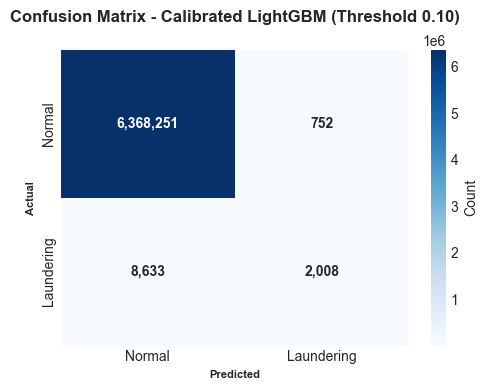

In [79]:

print("Best Model:Calibrated LightGBM (Threshold 0.10)")

cm = confusion_matrix(y_test, y_pred8_tuned)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', 
            xticklabels=['Normal', 'Laundering'],
            yticklabels=['Normal', 'Laundering'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 10, 'weight': 'bold'})
plt.title('Confusion Matrix - Calibrated LightGBM (Threshold 0.10)', 
          fontsize=12, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=8, fontweight='bold')
plt.xlabel('Predicted', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.show()

## Feature Importance

In [82]:
# Feature Importance for Best Model 
print("Feature Importance: Calibrated LightGBM")

base_model = model8_calibrated.calibrated_classifiers_[0].estimator

importance = base_model.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features")
display(feature_importance.head(20))

Feature Importance: Calibrated LightGBM

Top 20 Most Important Features


,Feature,Importance
1,To Bank,26530
0,From Bank,22524
8,hour,19124
2,Amount Received,15547
3,Amount Paid,14501
4,amount_zscore,13618
9,day_of_week,9547
19,risk_score_v2,3995
7,is_usd,2493
6,is_euro,2346


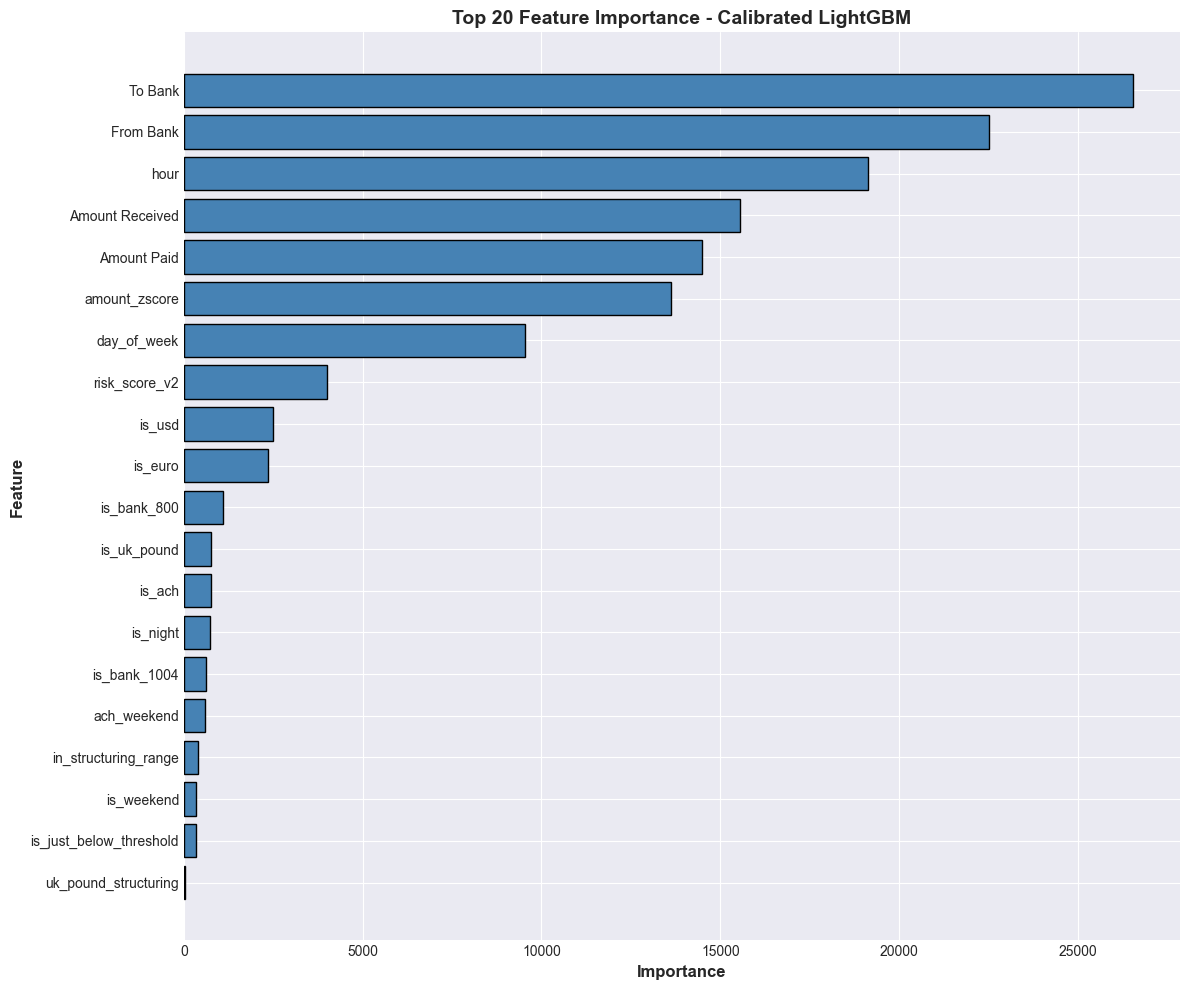

In [83]:

plt.figure(figsize=(12, 10))
plt.barh(feature_importance.head(20)['Feature'], 
         feature_importance.head(20)['Importance'],
         color='steelblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 20 Feature Importance - Calibrated LightGBM', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [84]:



# Save top features for hyperparameter tuning
top_features = feature_importance.head(15)['Feature'].tolist()
print(f"\nTop 15 features saved for hyperparameter tuning:")
print(top_features)


Top 15 features saved for hyperparameter tuning:
['To Bank', 'From Bank', 'hour', 'Amount Received', 'Amount Paid', 'amount_zscore', 'day_of_week', 'risk_score_v2', 'is_usd', 'is_euro', 'is_bank_800', 'is_uk_pound', 'is_ach', 'is_night', 'is_bank_1004']


Save Best Model

In [85]:
import joblib
import json
import os

print("Saving Model Calibrated LightGBM for Production...")


os.makedirs('../models', exist_ok=True)
top_15_features = ['To Bank', 'From Bank', 'hour', 'Amount Received', 'Amount Paid', 
                   'amount_zscore', 'day_of_week', 'risk_score_v2', 'is_usd', 'is_euro', 
                   'is_bank_800', 'is_uk_pound', 'is_ach', 'is_night', 'is_bank_1004']


model_path = '../models/calibrated_lightgbm_model.pkl'
joblib.dump(model8_calibrated, model_path)
print(f"Model saved: {model_path}")


Saving Model Calibrated LightGBM for Production...
Model saved: ../models/calibrated_lightgbm_model.pkl


In [86]:
# scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

Scaler saved: ../models/scaler.pkl


In [89]:
# features names
features_path = '../models/feature_names.json'
with open(features_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"Feature names saved: {features_path}")

# feature importance rankings
feature_importance_dict = feature_importance.to_dict('records')
importance_path = '../models/feature_importance.json'
with open(importance_path, 'w') as f:
    json.dump(feature_importance_dict, f, indent=2)
print(f"Feature importance saved: {importance_path}")
# top 15 important features
top_features_path = '../models/top_15_features.json'
with open(top_features_path, 'w') as f:
    json.dump(top_15_features, f, indent=2)
print(f"Top 15 features saved: {top_features_path}")

Feature names saved: ../models/feature_names.json
Feature importance saved: ../models/feature_importance.json
Top 15 features saved: ../models/top_15_features.json


In [90]:

#  model configuration and performance metrics
config = {
    'model_name': 'Calibrated LightGBM',
    'model_version': '1.0',
    'optimal_threshold': 0.10,
    'performance_metrics': {
        'precision': 0.7275,
        'recall': 0.1887,
        'f1_score': 0.2997,
        'roc_auc': 0.9781,
        'false_positive_rate': 0.0001,
        'true_positives': 2008,
        'false_positives': 752,
        'false_negatives': 8633,
        'true_negatives': 6368251
    },
    'training_info': {
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'num_features': len(feature_cols),
        'training_date': '2024-11-23',
        'dataset': 'IBM Synthetic AML (HI-Medium)',
        'total_transactions': '31.9M'
    },
    'hyperparameters': {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 8,
        'num_leaves': 256,
        'colsample_bytree': 0.7,
        'subsample': 0.8,
        'reg_lambda': 1.0,
        'scale_pos_weight': 1,
        'calibration_method': 'sigmoid',
        'calibration_cv': 3
    },
    'top_15_features': top_15_features
}

config_path = '../models/model_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Model configuration saved: {config_path}")

Model configuration saved: ../models/model_config.json


In [91]:


print("\n Model Performance Summary:")
print(f"   • Precision: 72.75% (When flagged, 73% are actual laundering)")
print(f"   • Recall: 18.87% (Catches 19% of all laundering cases)")
print(f"   • F1 Score: 29.97% (3.00x target)")
print(f"   • ROC-AUC: 97.81% (Excellent discrimination)")
print(f"   • False Positives: Only 752 out of 6.4M transactions (0.01%)")
print("\n🔝 Top 5 Most Important Features:")
for i, feat in enumerate(top_15_features[:5], 1):
    print(f"   {i}. {feat}")



 Model Performance Summary:
   • Precision: 72.75% (When flagged, 73% are actual laundering)
   • Recall: 18.87% (Catches 19% of all laundering cases)
   • F1 Score: 29.97% (3.00x target)
   • ROC-AUC: 97.81% (Excellent discrimination)
   • False Positives: Only 752 out of 6.4M transactions (0.01%)

🔝 Top 5 Most Important Features:
   1. To Bank
   2. From Bank
   3. hour
   4. Amount Received
   5. Amount Paid
